In [ ]:
<a href="https://colab.research.google.com/github/colinrsmall/ehm_faces/blob/master/notebooks/facepic_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Clone the repo from github

In [ ]:
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


cd into the directory

In [ ]:
cd stylegan/

/content/stylegan


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import pickle
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import moviepy.editor as mpy
from tqdm import tqdm_notebook as tqdm

tflib.init_tf()




Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4145152/45929032 bytes (9.0%)8167424/45929032 bytes (17.8%)12206080/45929032 bytes (26.6%)16146432/45929032 bytes (35.2%)20127744/45929032 bytes (43.8%)23977984/45929032 bytes (52.2%)27844608/45929032 bytes (60.6%)30736384/45929032 bytes (66.9%)34856960/45929032 bytes (75.9%)38944768/45929032 bytes (84.8%)43180032/45929032 bytes (94.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /r

In [ ]:
model = '/content/drive/My Drive/Colab Notebooks/new network snapshots/network-snapshot-011365.pkl'

with open(model, 'rb') as f:
    _G, _D, Gs = pickle.load(f)

fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
truncation = 0.8


def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def get_latent_interpolation_bspline(endpoints, nf, k, s, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    x = np.array(endpoints)
    x = np.append(x, x[0,:].reshape(1, x.shape[1]), axis=0)
    nd = x.shape[1]
    latents = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T


def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

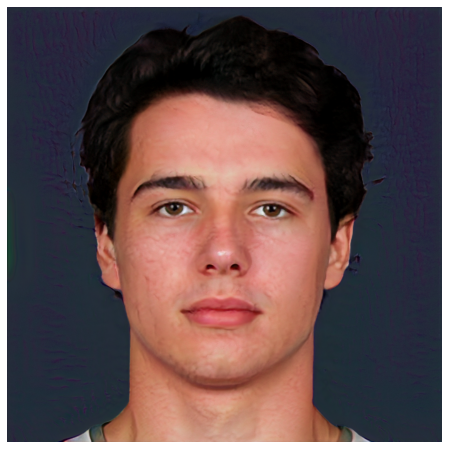

In [ ]:
#from google.colab import files

def random_sample(num_images, scale, psi):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    plt.axis('off')
    #plt.savefig('download.png')
    return images, latents

images, latents = random_sample(1, scale=8, psi=0.7)


#files.download('download.png')

In [ ]:
from google.colab import files
import time
for r in range(0, 10):
  for i in tqdm(range(0,500)):
          rnd = np.random.RandomState(None)
          latents = rnd.randn(1, Gs.input_shape[1])
          fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
          images = Gs.run(latents, None, truncation_psi=0.9, randomize_noise=True, output_transform=fmt)
          os.makedirs('/content/results', exist_ok=True)
          png_filename = os.path.join('/content/results', 'example-'+str(i)+'.png')
          im = PIL.Image.fromarray(images[0], 'RGB')
          im = im.resize((200, 200))
          im.save(png_filename)
  !zip '/content/drive/My Drive/pack_{r}.zip' '/content/results/' -r
  !rm -rf '/content/results'


  adding: content/results/ (stored 0%)
  adding: content/results/example-68.png (deflated 0%)
  adding: content/results/example-471.png (deflated 0%)
  adding: content/results/example-190.png (deflated 0%)
  adding: content/results/example-479.png (deflated 0%)
  adding: content/results/example-331.png (deflated 0%)
  adding: content/results/example-230.png (deflated 0%)
  adding: content/results/example-134.png (deflated 0%)
  adding: content/results/example-412.png (deflated 0%)
  adding: content/results/example-39.png (deflated 0%)
  adding: content/results/example-45.png (deflated 0%)
  adding: content/results/example-424.png (deflated 0%)
  adding: content/results/example-27.png (deflated 0%)
  adding: content/results/example-105.png (deflated 0%)
  adding: content/results/example-266.png (deflated 0%)
  adding: content/results/example-116.png (deflated 0%)
  adding: content/results/example-22.png (deflated 0%)
  adding: content/results/example-29.png (deflated 0%)
  adding: cont

KeyboardInterrupt: ignored

In [ ]:
while True:
  time.sleep(1)

In [ ]:
!rm -rf '/content/results'

Testing DB Generation

In [ ]:
import csv
with open('/content/output.csv', newline='', encoding='UTF-8', errors='ignore') as junior_players:
    junior_players = csv.reader(junior_players, delimiter=',')
    for player2 in next(junior_players):
      print(player2)
      rnd = np.random.RandomState(None)
      latents = rnd.randn(1, Gs.input_shape[1])
      fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
      images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
      os.makedirs('/content/results', exist_ok=True)
      png_filename = os.path.join('/content/results', player2)
      im = PIL.Image.fromarray(images[0], 'RGB')
      im = im.resize((200, 200))
      im.save(png_filename)
!zip '/content/drive/My Drive/junior_players.zip' '/content/results/' -r
!rm -rf '/content/results'